In [131]:
import numpy as np
from binomial import Binomial
from calibration import calibration
from rcn import rcn
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

Interest rate  -0.0078
Dividend yield 0.0278
------------------------------
Minimum found!
Func value     0.2349
Up             1.0826
Down           0.9685
------------------------------
               simc      Call         simp       Put
Strike                                              
12000    381.425584   381.525  1662.278436  1662.321
11800    420.498768   420.599  1499.785171  1499.822
11600    493.250207   493.332  1370.970162  1370.990
11400    571.298153   571.380  1247.451659  1247.470
11200    649.346099   649.428  1123.933157  1123.951
11000    727.394045   727.476  1000.414655  1000.440
10800    805.441991   805.524   876.896152   876.917
10600    883.489937   883.572   753.377650   753.399
10400    991.348798   991.344   659.670062   659.605
10200   1114.867300  1114.862   581.622116   581.557
10000   1238.385803  1238.381   503.574170   503.509
9800    1361.904305  1361.900   425.526223   425.461
9600    1485.422808  1485.422   347.478277   347.413
9400    1612.9141

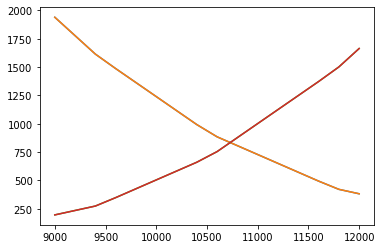

In [2]:
"""Run callibration file and return the interest rate, div yield, u and d"""
r, y, u, d = calibration()

## Question 1

In [3]:
T = 12
dt = 1/T
i0 = 11118
c = 0.1
alpha = 1
beta = 0.8

In [35]:

tree = Binomial(r, T, dt, i0, u, d, y)

print('{:10} : {:.4f}'.format(' rcn', tree.price_RCN(alpha, c)))
print('{:10} : {:.4f}'.format('brcn', tree.price_RCN(alpha, c, beta)))
print('{:10} : {:.4f}'.format('bond', tree.price_bond(c*dt)))

print()
note = rcn(r, dt, i0, y, u, d, c*dt, T)
print('{:10} : {:.4f}'.format(' rcn', note.price_rcn(alpha=alpha, c=c*dt)))
print('{:10} : {:.4f}'.format('brcn', note.price_brcn(alpha=alpha, beta=beta, c=c*dt)))
print('{:10} : {:.4f}'.format('bond', note.bond))


 rcn       : 0.7109
brcn       : 1.0078
bond       : 1.0078

 rcn       : 0.7109
brcn       : 1.0078
bond       : 1.0078


## Question 2

In [5]:
par_price = 1

def f(c, *args):
    alpha, beta, type = args
    if type == 'RCN': p = tree.price_RCN(alpha, c)
    if type == 'BRCN': p = tree.price_RCN(alpha, c, beta)
    return (par_price - p) ** 2

res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
print('alpha = {}, beta = {}'.format(alpha, beta))
if res_RCN.success: print('Par coupon for RCN:  c = {:.2%}'.format(res_RCN.x[0]))
if res_BRCN.success: print('Par coupon for BRCN: c = {:.2%}'.format(res_BRCN.x[0]))

alpha = 1, beta = 0.8
Par coupon for RCN:  c = 28.78%
Par coupon for BRCN: c = 25.40%


In [6]:
res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(betas):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
        brcn_c[i,j] = res_BRCN.x[0]*100

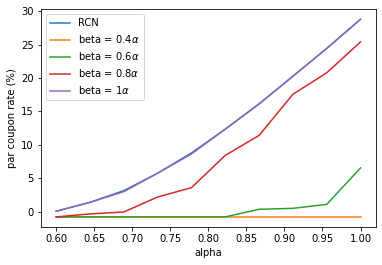

In [7]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

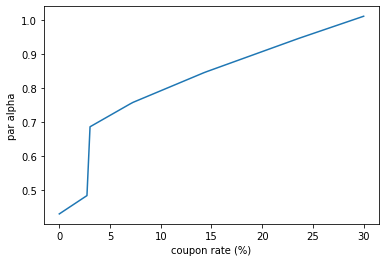

In [59]:
coupons = np.linspace(0, 0.30, 100)
par_price = 1

def g(alpha, *args):
    c, = args
    return (par_price - tree.price_RCN(alpha, c)) ** 2

alphas = []
for c in coupons:
    res = minimize(g, 1, args=(c))
    alphas.append(res.x[0])

plt.plot(coupons*100, alphas)
plt.xlabel('coupon rate (%)')
plt.ylabel('par alpha')
plt.show(tree.price_RCN(alpha, c))

In [235]:
def h(alpha, *args):
    c, rate = args
    return (par_price - tree.price_RCN(alpha, c, rate*alpha)) ** 2


coupons = np.linspace(0, 0.30, 100)
rates = [0.4, 0.6, 0.8, 1]
#betas = np.outer(coupons, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0.5})

brcn_alpha = []

for i, r in enumerate(rates):
    row= []
    for j, c in enumerate(tqdm(coupons)):
        c = coupons[j]
        if r==0.4 or r==0.6:
            start = 0.95
        else:
            start=0.8
        res_BRCN = minimize(h, start, args=(c, r), constraints=cons)
        row.append(res_BRCN.x[0])
        #print(res_BRCN.x[0])
    print(row)
    brcn_alpha.append(row)
print(brcn_alpha)

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9602228862884002, 0.9588845809677877, 0.960139686387495, 0.9580529365209287, 0.9606730735587476, 0.9614904048764876, 0.9606672558635408, 0.9603637177135942, 0.9605657482819148, 0.9608107083780933, 0.9604146449044947, 0.9677692970432847, 0.9757405813317745, 0.9889446123894334, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

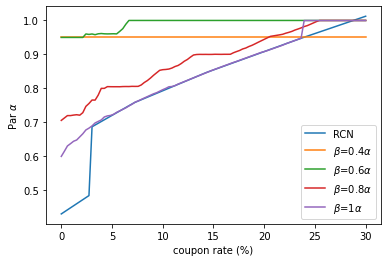

In [236]:
plt.plot(coupons*100, alphas, label='RCN')

for i, r in enumerate(rates):
    plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()